In [1]:
import relational_image_generation_evaluation as rige

In [2]:
evaluator = rige.Evaluator('ViT-L/14')
dataloader_one = rige.get_one_edge_dataloader(testonly=True)
dataloader_two = rige.get_two_edge_dataloader(testonly=True)
dataloader_full = rige.get_full_graph_dataloader(testonly=True)
print("len(dataloader_one):", len(dataloader_one))
print("len(dataloader_two):", len(dataloader_two))

Using device cuda:1 for evaluation.
Using text embeddings as input to the model.
Loading filtered test graphs...
Finished loading filtered test graphs
Generating one edge graphs...


100%|██████████| 100/100 [00:00<00:00, 1056.99it/s]

Finished generating one edge graphs
Loading filtered test graphs...
Finished loading filtered test graphs
Generating two edge graphs...



100%|██████████| 100/100 [00:00<00:00, 891.91it/s]


Finished generating two edge graphs
Loading filtered test graphs...
Finished loading filtered test graphs
len(dataloader_one): 837
len(dataloader_two): 1076


In [3]:
from PIL import Image
images = []
graphs = []
for i in range(10):
    graph = next(iter(dataloader_one))[0]
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    images.append(image)
    graphs.append(graph)

In [4]:
scores = evaluator(images,graphs)
print(scores)
print(scores.keys())

{'rel_scores': [0.9963749051094055, 0.9753934741020203, 0.9214745163917542, 0.9958992600440979, 0.8125936388969421, 0.7544750571250916, 0.4216979146003723, 0.9317278861999512, 0.9186421036720276, 0.012344365939497948], 'attr_scores': [0.15855653584003448, 0.7651040554046631, 0.9766125679016113, 0.34666815400123596, 0.18600665032863617, 'noattributes', 0.11902481317520142, 0.25954243540763855, 0.3700721263885498, 0.07474261522293091]}
dict_keys(['rel_scores', 'attr_scores'])


In [5]:
images = []
graphs = []
for i in range(10):
    graph = next(iter(dataloader_two))[0]
    assert len(graph.edges) == 2, f"Graph does not have two edges: {graph.edges}"
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # image = image.convert('RGB')
    images.append(image)
    graphs.append(graph)

In [6]:
scores = evaluator(images,graphs)
print(scores)
print(scores.keys())

{'rel_scores': [0.9885056614875793, 0.9839268326759338, 8.248157428170089e-07, 0.9772341847419739, 0.9576905965805054, 0.523443341255188, 0.8659615516662598, 0.8880363702774048, 0.8659616112709045, 0.8461143970489502], 'attr_scores': [0.5559964179992676, 'noattributes', 0.24270299077033997, 'noattributes', 0.5323565006256104, 0.6055250763893127, 0.40389275550842285, 0.5705788731575012, 0.40389296412467957, 0.26415884494781494]}
dict_keys(['rel_scores', 'attr_scores'])


In [7]:
from PIL import Image

images_orig = []
graphs_orig = []
images_adv = []
graphs_adv = []
for i in range(300):
    graph = next(iter(dataloader_one))[0]
    assert len(graph.edges) == 1, f"Graph does not have one edge: {graph.edges}"
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image_orig = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    image_adv = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # image = image.convert('RGB')
    images_orig.append(image_orig)
    graphs_orig.append(graph)
    graph_adv = rige.copy_graph(graph)
    # flip the attributes of the two nodes in the graph
    [n1,n2] = list(graph_adv.nodes)[0:2]
    graph_adv.nodes[n1]['attributes'], graph_adv.nodes[n2]['attributes'] = graph_adv.nodes[n2]['attributes'], graph_adv.nodes[n1]['attributes']
    images_adv.append(image_adv)
    graphs_adv.append(graph_adv)
scores_orig = evaluator(images_orig,graphs_orig)
scores_adv = evaluator(images_adv,graphs_adv)
print(scores_orig['attr_scores'])
print(scores_adv['attr_scores'])

['noattributes', 0.15855655074119568, 'noattributes', 0.3813652992248535, 'noattributes', 'noattributes', 0.4027596414089203, 0.5549305081367493, 'noattributes', 'noattributes', 0.5059268474578857, 0.34000304341316223, 0.42295584082603455, 0.4038931429386139, 'noattributes', 0.49560895562171936, 0.0864562839269638, 'noattributes', 0.6534953117370605, 0.23712939023971558, 0.028290022164583206, 0.4048355519771576, 'noattributes', 0.40389305353164673, 0.5688793063163757, 'noattributes', 0.568879246711731, 0.714468777179718, 0.29095205664634705, 0.16564823687076569, 0.28223586082458496, 0.5526719689369202, 0.0007241009152494371, 'noattributes', 'noattributes', 'noattributes', 0.06281307339668274, 'noattributes', 0.0477331206202507, 0.13036774098873138, 'noattributes', 0.35067781805992126, 'noattributes', 0.04443687945604324, 0.525521993637085, 0.17989161610603333, 'noattributes', 0.7651039361953735, 0.3132937550544739, 'noattributes', 0.6558380722999573, 0.9041731357574463, 0.2717391848564

In [8]:
# print how often the model was more confident in the good graph
n_good = 0
n_bad = 0
for orig,adv in zip(scores_orig['attr_scores'],scores_adv['attr_scores']):
    if orig == 'noattributes':
        continue
    if orig == adv:
        n_good += 0.5
        print("warning, this is unlikely to happen")
    elif orig>adv:
        n_good += 1
    else:
        n_bad += 1

print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")

n_correct: 185, n_incorrect: 15, accuracy: 0.925


# Evaluate on Robert's dataset

In [9]:
import relational_image_generation_evaluation as rige

In [10]:
import json
path = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/realistic_adversarial_attributes_gt_accepted_pruned.json'
with open(path, 'r') as f:
    data = json.load(f)
    print(len(data))

100


In [11]:
display(data[0])

{'image_id': 107907,
 'relationships': [],
 'objects': [{'synsets': ['grass.n.01'],
   'h': 229,
   'object_id': 1037497,
   'names': ['grass'],
   'w': 476,
   'attributes': ['green'],
   'y': 536,
   'x': 147},
  {'synsets': ['tree.n.01'],
   'h': 304,
   'object_id': 1037502,
   'names': ['tree'],
   'w': 156,
   'attributes': ['dead'],
   'y': 22,
   'x': 4}]}

In [12]:
import networkx as nx
graphs = []
for sample in data:
    graph = nx.DiGraph()
    graph.image_id = sample['image_id']
    obj1_name = sample['objects'][0]['names'][0]
    obj1_id = sample['objects'][0]['object_id']
    obj2_name = sample['objects'][1]['names'][0]
    obj2_id = sample['objects'][1]['object_id']
    obj1_attrs = sample['objects'][0]['attributes']
    obj2_attrs = sample['objects'][1]['attributes']
    assert obj1_name in rige.FILTERED_OBJECTS, f"obj1_attrs: {obj1_attrs}"
    assert obj2_name in rige.FILTERED_OBJECTS, f"obj2_attrs: {obj2_attrs}"
    for attr in obj1_attrs:
        assert attr in rige.FILTERED_ATTRIBUTES, f"obj1_attrs: {obj1_attrs}"
    for attr in obj2_attrs:
        assert attr in rige.FILTERED_ATTRIBUTES, f"obj2_attrs: {obj2_attrs}"
    # add nodes with attributes and labels
    graph.labels = {}
    graph.add_node(obj1_id, attributes=obj1_attrs, name=obj1_name)
    graph.labels[obj1_id] = obj1_name
    graph.add_node(obj2_id, attributes=obj2_attrs, name=obj2_name)
    graph.labels[obj2_id] = obj2_name
    graphs.append(graph)

In [13]:
evaluator = rige.Evaluator('ViT-L/14')

Using device cuda:3 for evaluation.
Using text embeddings as input to the model.


In [14]:
from PIL import Image

images_orig = []
graphs_orig = []
images_adv = []
graphs_adv = []
for graph in graphs:
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image_orig = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    image_adv = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # image = image.convert('RGB')
    images_orig.append(image_orig)
    graphs_orig.append(graph)
    graph_adv = rige.copy_graph(graph)
    # flip the attributes of the two nodes in the graph
    [n1,n2] = list(graph_adv.nodes)[0:2]
    graph_adv.nodes[n1]['attributes'], graph_adv.nodes[n2]['attributes'] = graph_adv.nodes[n2]['attributes'], graph_adv.nodes[n1]['attributes']
    images_adv.append(image_adv)
    graphs_adv.append(graph_adv)
scores_orig = evaluator(images_orig,graphs_orig)
scores_adv = evaluator(images_adv,graphs_adv)
print(scores_orig['attr_scores'])
print(scores_adv['attr_scores'])

[0.5067169070243835, 0.5126994252204895, 0.014939935877919197, 0.05341831594705582, 0.35333964228630066, 0.5326796770095825, 0.596204936504364, 0.43216267228126526, 0.8438869118690491, 0.19870752096176147, 0.40836358070373535, 0.30747607350349426, 0.014071587473154068, 0.30224454402923584, 0.3189971446990967, 0.8700500130653381, 0.4589890241622925, 0.48020413517951965, 0.4660986065864563, 0.39961034059524536, 0.8092803955078125, 0.13676051795482635, 0.9554259181022644, 0.34916573762893677, 0.18107426166534424, 0.47316527366638184, 0.268600195646286, 0.44982922077178955, 0.27271461486816406, 0.15753060579299927, 0.4582934081554413, 0.03702370822429657, 0.23769105970859528, 0.2652689516544342, 0.09565043449401855, 0.2229176163673401, 0.010786314494907856, 0.8500231504440308, 0.0007952181622385979, 0.803155779838562, 0.6283320188522339, 0.4280906021595001, 0.5244414806365967, 0.8952537178993225, 0.6321173906326294, 0.344717800617218, 0.24998712539672852, 0.340531587600708, 0.2154928743839

In [15]:
# print how often the model was more confident in the good graph
n_good = 0
n_bad = 0
wrong_indices = []
for i,(orig,adv) in enumerate(zip(scores_orig['attr_scores'],scores_adv['attr_scores'])):
    if orig == 'noattributes':
        continue
    if orig == adv:
        n_good += 0.5
        print("warning, this is unlikely to happen")
    elif orig>adv:
        n_good += 1
    else:
        n_bad += 1
        wrong_indices.append(i)

print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")

n_correct: 91, n_incorrect: 9, accuracy: 0.91


150476
bus  with attributes:  ['white']
truck  with attributes:  ['purple']
0.46110546588897705
0.48888206481933594


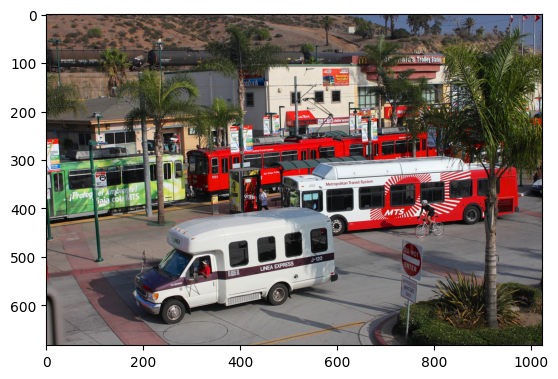

150476
bus  with attributes:  ['red']
truck  with attributes:  ['purple']
0.5453855991363525
0.5539563894271851


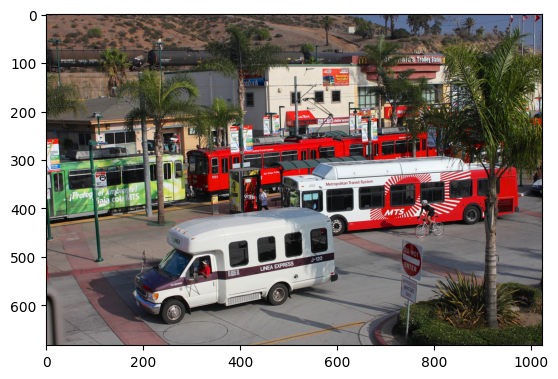

1593095
man  with attributes:  ['brown']
basket  with attributes:  ['large']
0.40451276302337646
0.6634249687194824


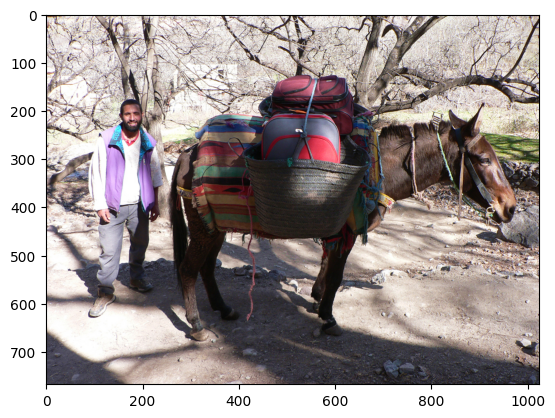

2410959
cake  with attributes:  ['blue']
plate  with attributes:  ['gray']
0.31070244312286377
0.31434252858161926


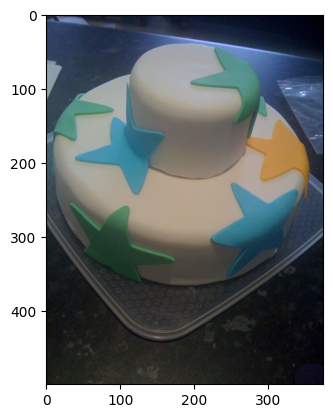

2410959
cake  with attributes:  ['round']
plate  with attributes:  ['gray']
0.42010873556137085
0.4894157946109772


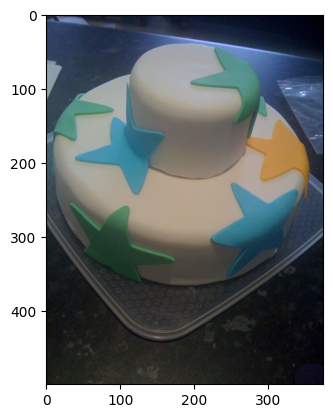

2409217
sign  with attributes:  ['large']
building  with attributes:  ['red']
0.25778838992118835
0.6824603080749512


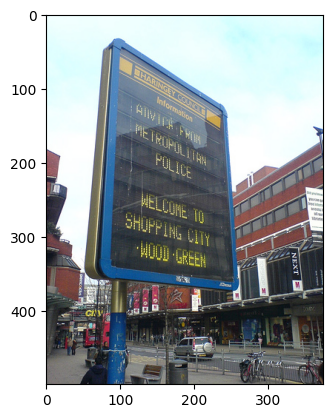

2408695
fence  with attributes:  ['gray']
sky  with attributes:  ['orange']
0.4617457985877991
0.5855066776275635


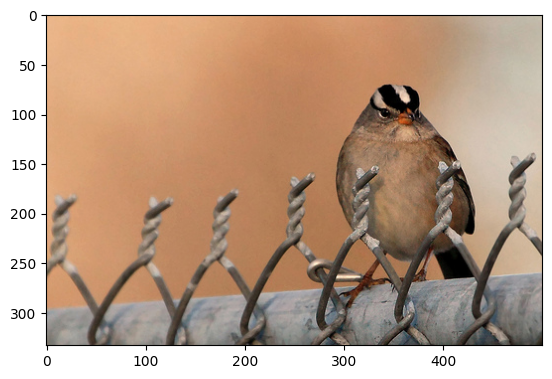

4
frame  with attributes:  ['wooden']
table  with attributes:  ['metal']
0.5964887142181396
0.7379393577575684


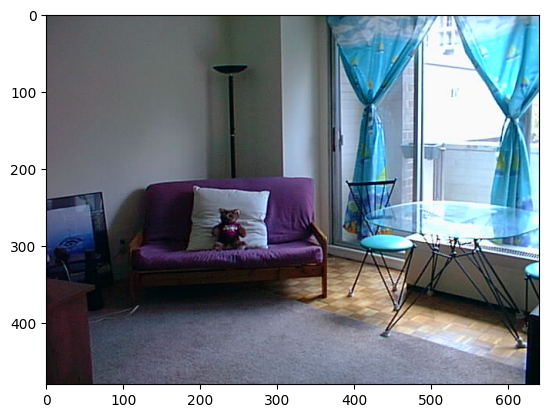

18
shelf  with attributes:  ['wooden']
floor  with attributes:  ['black']
0.5855445861816406
0.595445454120636


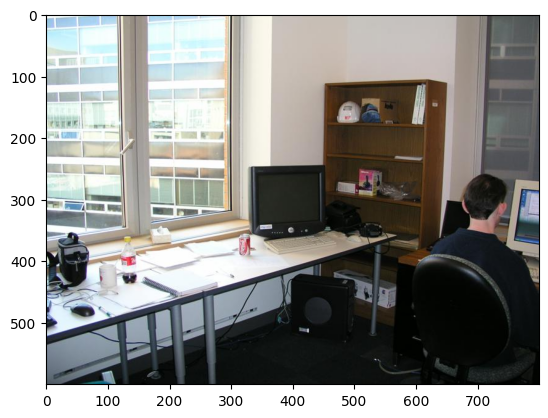

21
shirt  with attributes:  ['white']
pillow  with attributes:  ['plaid']
0.14312313497066498
0.6921268701553345


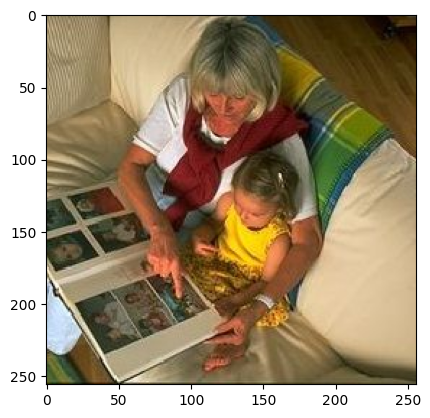

85
chair  with attributes:  ['gray']
couch  with attributes:  ['white']
0.30595114827156067
0.3150324821472168


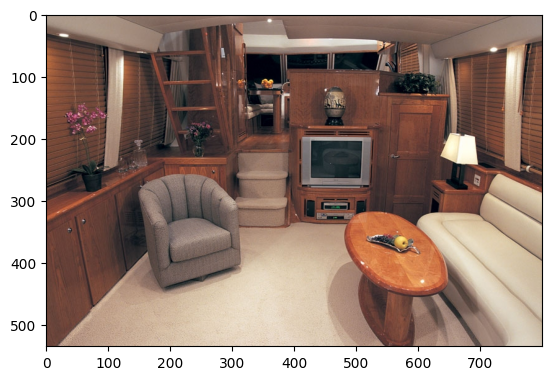

115
top  with attributes:  ['white']
shirt  with attributes:  ['yellow']
0.11123357713222504
0.1906510591506958


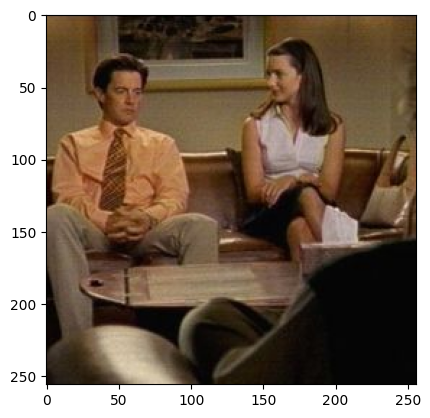

174
floor  with attributes:  ['gray']
wall  with attributes:  ['wood']
0.5980803370475769
0.6039218306541443


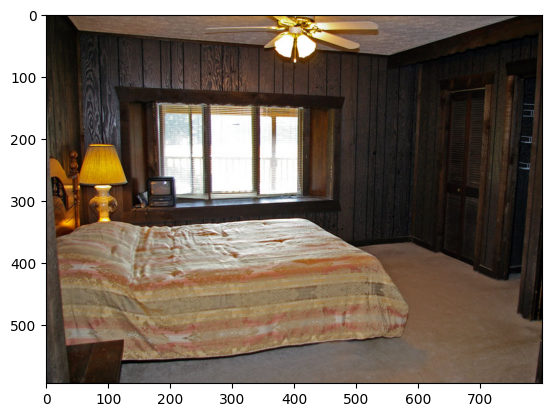

213
roof  with attributes:  ['green']
tree  with attributes:  ['colorful']
0.23115721344947815
0.38929980993270874


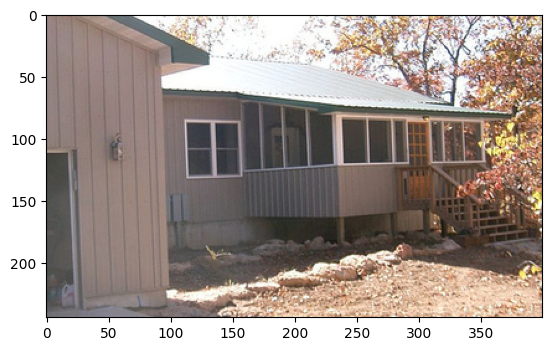

271
fence  with attributes:  ['beige']
road  with attributes:  ['black']
0.18911443650722504
0.2610165476799011


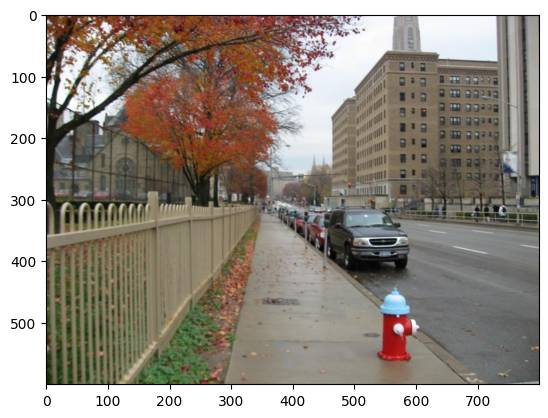

329
desk  with attributes:  ['white']
chair  with attributes:  ['brown']
0.585541307926178
0.5859597325325012


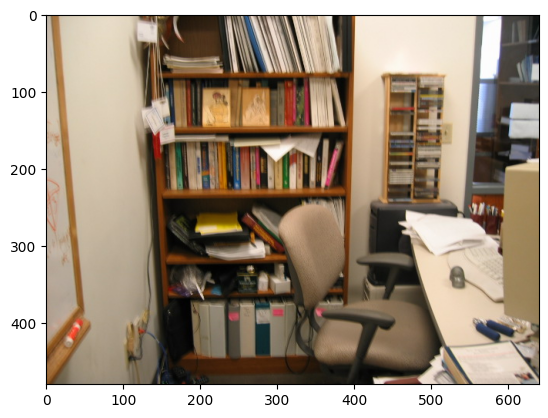

334
wall  with attributes:  ['white']
counter  with attributes:  ['beige']
0.4786843955516815
0.6482272148132324


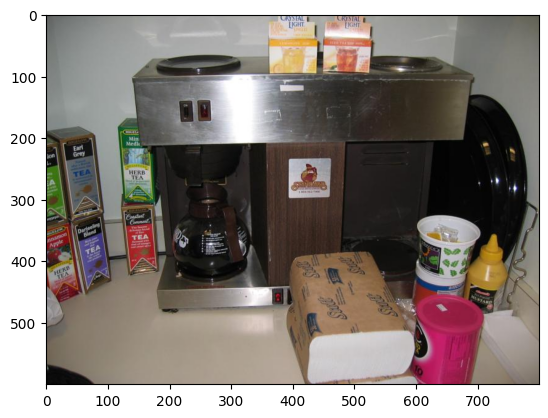

375
hat  with attributes:  ['white']
book  with attributes:  ['paper']
0.7400079965591431
0.763001561164856


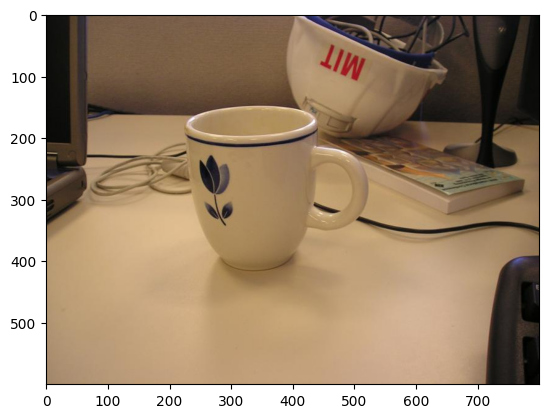

531
flowers  with attributes:  ['green']
fence  with attributes:  ['white']
0.2743276357650757
0.2758576571941376


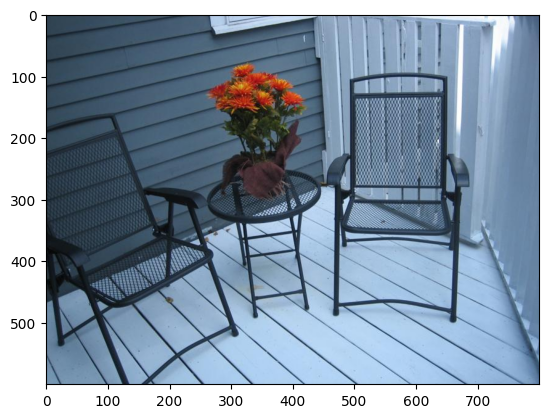

2402459
airplane  with attributes:  ['green']
ground  with attributes:  ['white']
0.3233743906021118
0.3956158757209778


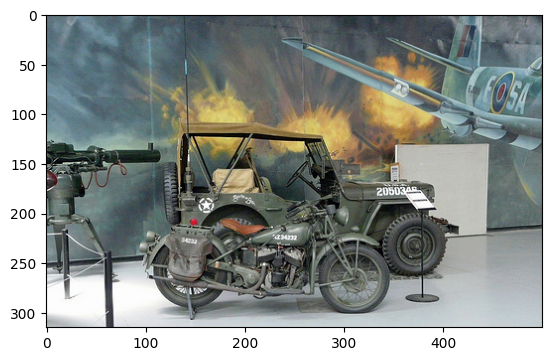

2402196
box  with attributes:  ['white']
wall  with attributes:  ['brown']
0.5049862861633301
0.6404540538787842


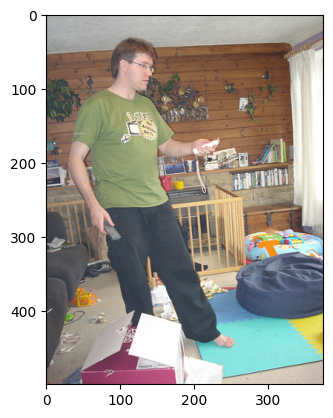

2402010
cake  with attributes:  ['brown']
table  with attributes:  ['white']
0.5959000587463379
0.6387748122215271


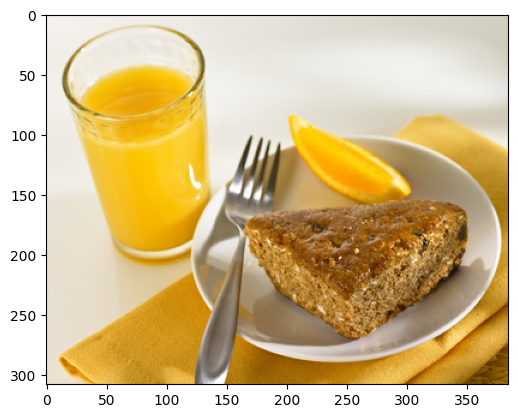

2397222
bag  with attributes:  ['black']
shorts  with attributes:  ['white']
0.5269876718521118
0.6371327638626099


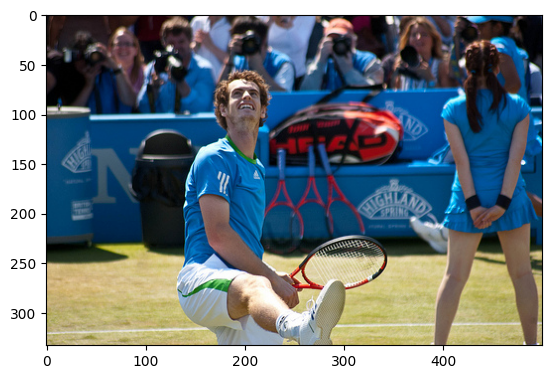

2395832
sky  with attributes:  ['bright']
bench  with attributes:  ['blue']
0.30319279432296753
0.4834897518157959


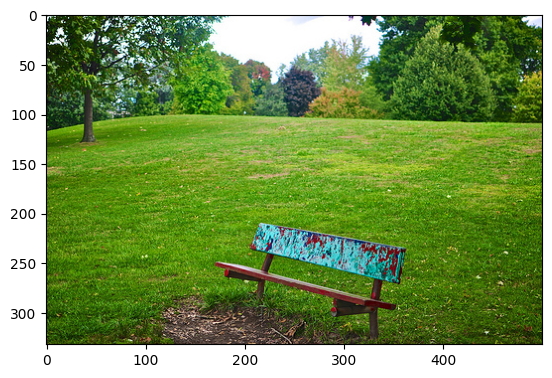

In [24]:
import matplotlib.pyplot as plt
for i,graph in enumerate(graphs):
    if i in wrong_indices:
        print(graph.image_id)
        obj1_name = graph.nodes[list(graph.nodes)[0]]['name']
        obj2_name = graph.nodes[list(graph.nodes)[1]]['name']
        print(obj1_name, " with attributes: ", graph.nodes[list(graph.nodes)[0]]['attributes'])
        print(obj2_name, " with attributes: ", graph.nodes[list(graph.nodes)[1]]['attributes'])
        print(scores_orig['attr_scores'][i])
        print(scores_adv['attr_scores'][i])
        # plot the image
        IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
        image = Image.open(IMAGE_DIR + str(graph.image_id) + '.jpg')
        plt.imshow(image)
        plt.show()